<a href="https://colab.research.google.com/github/YouMinJung/Melbourne_Temperature_Forecasting/blob/main/Temperature_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Forecast the Temperature

Using temperature data, forecast the future temperature.

In [2]:
import requests
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass

## Load Dataset

I will use [Daily Minimum Temperatures in Melbourne](https://github.com/jbrownlee/Datasets/blob/master/daily-min-temperatures.csv) dataset.

This dataset contains data of the daily minimum temperatures recorded in Melbourne from 1981 to 1990.

In [5]:
TEMPERATURES_CSV = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'

res = requests.get(TEMPERATURES_CSV)
with open('./daily-min-temperatures.csv','w+', encoding='utf-8') as file:
    file.write(res.content.decode('utf-8'))

with open('./daily-min-temperatures.csv', 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")    
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")



Header looks like this:

"Date","Temp"

First data point looks like this:

"1981-01-01",20.7

Second data point looks like this:

"1981-01-02",17.9



In [6]:
def parse_data_from_file(filename):
    
    times = []
    temperatures = []

    with open(filename) as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        
        step = 0
        for row in reader:
            times.append(step)
            step = step + 1
            temperatures.append(float(row[1]))
               
    return times, temperatures

## Draw temperature data with timeline

In [7]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

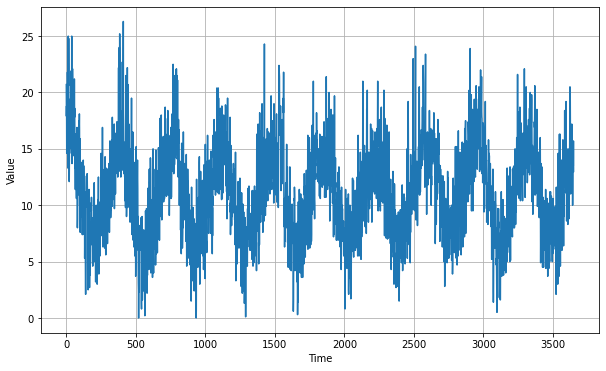

In [9]:
@dataclass
class G:
    TEMPERATURES_CSV = './daily-min-temperatures.csv'
    times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    TIME = np.array(times)
    SERIES = np.array(temperatures)
    SPLIT_TIME = 2500
    WINDOW_SIZE = 64
    BATCH_SIZE = 256
    SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

## Processing the data



In [10]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [11]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

## Defining the model architecture

In [12]:
def create_uncompiled_model():

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=1, activation="relu", padding='causal', input_shape=[None, 1]),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1)
    ]) 

    return model

## Adjusting the learning rate

In [13]:
def adjust_learning_rate(dataset):
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))
    optimizer = tf.keras.optimizers.SGD(momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"]) 

    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [14]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_set)

Epoch 1/100
10/10 [==============================] - 16s 39ms/step - loss: 10.4355 - mae: 10.9349 - lr: 1.0000e-04
Epoch 2/100
10/10 [==============================] - 0s 32ms/step - loss: 10.3355 - mae: 10.8348 - lr: 1.1220e-04
Epoch 3/100
10/10 [==============================] - 0s 30ms/step - loss: 10.2190 - mae: 10.7180 - lr: 1.2589e-04
Epoch 4/100
10/10 [==============================] - 0s 30ms/step - loss: 10.0929 - mae: 10.5917 - lr: 1.4125e-04
Epoch 5/100
10/10 [==============================] - 0s 29ms/step - loss: 10.0037 - mae: 10.5025 - lr: 1.5849e-04
Epoch 6/100
10/10 [==============================] - 0s 31ms/step - loss: 9.9172 - mae: 10.4159 - lr: 1.7783e-04
Epoch 7/100
10/10 [==============================] - 1s 64ms/step - loss: 9.8173 - mae: 10.3159 - lr: 1.9953e-04
Epoch 8/100
10/10 [==============================] - 1s 74ms/step - loss: 9.7069 - mae: 10.2055 - lr: 2.2387e-04
Epoch 9/100
10/10 [==============================] - 1s 74ms/step - loss: 9.5781 - mae: 10

(0.0001, 10.0, 0.0, 10.0)

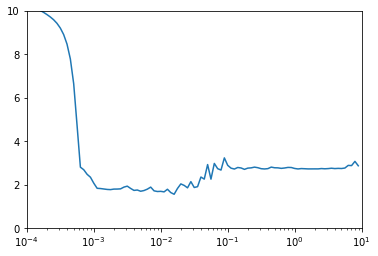

In [15]:
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-4, 10, 0, 10])

-> 1e-3 is the reasonable learning rate

## Compiling the model

In [16]:
def create_model():

    model = create_uncompiled_model()
    model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9), metrics=["mae"])  

    return model

In [17]:
# Save an instance of the model
model = create_model()

# Train
history = model.fit(train_set, epochs=500)

Epoch 1/500
10/10 [==============================] - 3s 26ms/step - loss: 10.1300 - mae: 10.6289
Epoch 2/500
10/10 [==============================] - 0s 32ms/step - loss: 9.5561 - mae: 10.0546
Epoch 3/500
10/10 [==============================] - 0s 32ms/step - loss: 8.6451 - mae: 9.1435
Epoch 4/500
10/10 [==============================] - 0s 31ms/step - loss: 6.9241 - mae: 7.4170
Epoch 5/500
10/10 [==============================] - 0s 32ms/step - loss: 3.7976 - mae: 4.2714
Epoch 6/500
10/10 [==============================] - 0s 30ms/step - loss: 2.9701 - mae: 3.4424
Epoch 7/500
10/10 [==============================] - 0s 33ms/step - loss: 2.6125 - mae: 3.0778
Epoch 8/500
10/10 [==============================] - 0s 31ms/step - loss: 2.5629 - mae: 3.0242
Epoch 9/500
10/10 [==============================] - 0s 30ms/step - loss: 2.3801 - mae: 2.8422
Epoch 10/500
10/10 [==============================] - 0s 31ms/step - loss: 2.1640 - mae: 2.6232
Epoch 11/500
10/10 [==========================

## Faster model forecast

In [18]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

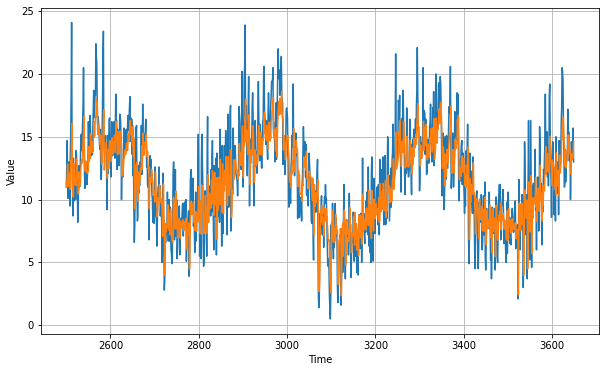

In [19]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

## Evaluating the forecast

In [20]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

In [21]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 5.24, mae: 1.79 for forecast
